In [1]:
pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error, mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import random_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import StandardScaler
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from sklearn.preprocessing import FunctionTransformer
%matplotlib inline
plt.style.use('seaborn')

<ipython-input-2-8d776a0bd691>:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
filePath = '/content/drive/MyDrive'

# Carga de variables obtenidas del dataset satelital y ajuste de las mismas para el programa ETo Calculator

In [9]:
df_time_series_var = pd.read_excel(f'{filePath}/Finca_SanLuis_dataset_variables_sat_ERA5_ETo_2015_2024.xlsx',dtype={'Bandvalue_dewpoint_temperature_2m': 'str', 'Bandvalue_temperature_2m_max': 'str', 'Bandvalue_temperature_2m_min': 'str', 'Bandvalue_u_component_of_wind_10m': 'str', 'Bandvalue_v_component_of_wind_10m': 'str', 'Bandvalue_surface_net_solar_radiation_sum': 'str'})


In [10]:
df_time_series_var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3296 entries, 0 to 3295
Data columns (total 7 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Band name                                  3296 non-null   object
 1   Bandvalue_dewpoint_temperature_2m          3296 non-null   object
 2   Bandvalue_temperature_2m_max               3296 non-null   object
 3   Bandvalue_temperature_2m_min               3296 non-null   object
 4   Bandvalue_u_component_of_wind_10m          3296 non-null   object
 5   Bandvalue_v_component_of_wind_10m          3296 non-null   object
 6   Bandvalue_surface_net_solar_radiation_sum  3296 non-null   object
dtypes: object(7)
memory usage: 180.4+ KB


In [ ]:
df_time_series_var

,Band name,Bandvalue_dewpoint_temperature_2m,Bandvalue_temperature_2m_max,Bandvalue_temperature_2m_min,Bandvalue_u_component_of_wind_10m,Bandvalue_v_component_of_wind_10m,Bandvalue_surface_net_solar_radiation_sum
0,20150101_dewpoint_temperature_2m,282763,298719,288302,0.296,0.434,"19,794,414"
1,20150102_dewpoint_temperature_2m,282314,299247,287951,0.302,0.555,"20,073,596"
2,20150103_dewpoint_temperature_2m,281193,299647,287715,0.321,0.702,"20,456,188"
3,20150104_dewpoint_temperature_2m,280649,299578,287415,0.404,0.635,"20,561,348"
4,20150105_dewpoint_temperature_2m,281292,298.42,286735,0.368,0.365,"18,997,464"
...,...,...,...,...,...,...,...
3291,20240105_dewpoint_temperature_2m,287579,298767,288383,0.239,-0.239,"17,874,362"
3292,20240106_dewpoint_temperature_2m,284275,300082,287374,0.333,0.528,"20,198,328"
3293,20240107_dewpoint_temperature_2m,282745,300047,288278,0.344,0.316,"20,036,442"
3294,20240108_dewpoint_temperature_2m,282985,300342,288374,0.354,0.379,"20,747,802"


In [ ]:
df_time_series_var_sat=df_time_series_var.copy()
df_time_series_var_sat['date'] = pd.to_datetime(df_time_series_var_sat['Band name'], format='%Y%m%d_dewpoint_temperature_2m').dt.date
df_time_series_var_sat=df_time_series_var_sat.drop(['Band name'],axis=1)
df_time_series_var_sat

,Bandvalue_dewpoint_temperature_2m,Bandvalue_temperature_2m_max,Bandvalue_temperature_2m_min,Bandvalue_u_component_of_wind_10m,Bandvalue_v_component_of_wind_10m,Bandvalue_surface_net_solar_radiation_sum,date
0,282763,298719,288302,0.296,0.434,"19,794,414",2015-01-01
1,282314,299247,287951,0.302,0.555,"20,073,596",2015-01-02
2,281193,299647,287715,0.321,0.702,"20,456,188",2015-01-03
3,280649,299578,287415,0.404,0.635,"20,561,348",2015-01-04
4,281292,298.42,286735,0.368,0.365,"18,997,464",2015-01-05
...,...,...,...,...,...,...,...
3291,287579,298767,288383,0.239,-0.239,"17,874,362",2024-01-05
3292,284275,300082,287374,0.333,0.528,"20,198,328",2024-01-06
3293,282745,300047,288278,0.344,0.316,"20,036,442",2024-01-07
3294,282985,300342,288374,0.354,0.379,"20,747,802",2024-01-08


In [ ]:
print("Number of missing values: ", df_time_series_var_sat.isnull().sum().sum())
print("Número de valores na: "),df_time_series_var_sat.isna().sum()

Number of missing values:  0
Número de valores na: 


(None,
 Bandvalue_dewpoint_temperature_2m            0
 Bandvalue_temperature_2m_max                 0
 Bandvalue_temperature_2m_min                 0
 Bandvalue_u_component_of_wind_10m            0
 Bandvalue_v_component_of_wind_10m            0
 Bandvalue_surface_net_solar_radiation_sum    0
 date                                         0
 dtype: int64)

Temperature

In [ ]:
columns_to_process = ['Bandvalue_dewpoint_temperature_2m', 'Bandvalue_temperature_2m_min', 'Bandvalue_temperature_2m_max']
def pad_with_zeros(value):
    if '.' in value:
      value =value.replace('.','')
      return value.ljust(6,'0')
    return value

def to_float_3dec(value):
    valueint=value[:3]
    valuedec=value[3:]
    value=valueint + '.' + valuedec
    return value

def kelvin_to_celsius(value):
    value = value - 273.15
    return value

for col in columns_to_process:
    df_time_series_var_sat[col] = df_time_series_var_sat[col].apply(pad_with_zeros)
    df_time_series_var_sat[col] = df_time_series_var_sat[col].apply(to_float_3dec)
    df_time_series_var_sat[col] = df_time_series_var_sat[col].astype(float)
    df_time_series_var_sat[col] = df_time_series_var_sat[col].apply(kelvin_to_celsius)
    df_time_series_var_sat[col] = df_time_series_var_sat[col].round(2)


In [ ]:
df_time_series_var_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3296 entries, 0 to 3295
Data columns (total 7 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Bandvalue_dewpoint_temperature_2m          3296 non-null   float64
 1   Bandvalue_temperature_2m_max               3296 non-null   float64
 2   Bandvalue_temperature_2m_min               3296 non-null   float64
 3   Bandvalue_u_component_of_wind_10m          3296 non-null   object 
 4   Bandvalue_v_component_of_wind_10m          3296 non-null   object 
 5   Bandvalue_surface_net_solar_radiation_sum  3296 non-null   object 
 6   date                                       3296 non-null   object 
dtypes: float64(3), object(4)
memory usage: 180.4+ KB


In [ ]:
df_time_series_var_sat.head(20)

,Bandvalue_dewpoint_temperature_2m,Bandvalue_temperature_2m_max,Bandvalue_temperature_2m_min,Bandvalue_u_component_of_wind_10m,Bandvalue_v_component_of_wind_10m,Bandvalue_surface_net_solar_radiation_sum,date
0,9.61,25.57,15.15,0.296,0.434,"19,794,414",2015-01-01
1,9.16,26.10,14.80,0.302,0.555,"20,073,596",2015-01-02
2,8.04,26.50,14.56,0.321,0.702,"20,456,188",2015-01-03
3,7.50,26.43,14.27,0.404,0.635,"20,561,348",2015-01-04
4,8.14,25.27,13.59,0.368,0.365,"18,997,464",2015-01-05
5,8.35,25.73,14.75,0.28,0.582,"20,029,196",2015-01-06
6,7.46,25.49,14.43,0.345,0.372,"19,268,220",2015-01-07
7,10.14,25.10,15.41,0.242,0.016,"15,996,166",2015-01-08
8,11.81,25.83,15.80,0.202,0.328,"16,682,842",2015-01-09
9,11.39,24.85,15.78,0.181,0.455,"15,334,086",2015-01-10


In [ ]:
df_time_series_var_sat[~df_time_series_var_sat['Bandvalue_v_component_of_wind_10m'].str.contains('\.')]

,Bandvalue_dewpoint_temperature_2m,Bandvalue_temperature_2m_max,Bandvalue_temperature_2m_min,Bandvalue_u_component_of_wind_10m,Bandvalue_v_component_of_wind_10m,Bandvalue_surface_net_solar_radiation_sum,date
49,16.32,23.33,17.11,-0.004,-1314,"13,280,504",2015-02-19
50,15.65,24.27,16.77,-0.106,-1084,"15,532,042",2015-02-20
166,13.09,25.66,16.29,-0.017,1427,"16,388,406",2015-06-16
167,13.68,26.09,16.60,-0.034,1151,"16,260,422",2015-06-17
168,12.70,25.87,16.39,0.031,1289,"13,591,466",2015-06-18
...,...,...,...,...,...,...,...
3126,13.09,26.01,16.67,-0.006,1305,"16,135,250",2023-07-24
3132,13.85,27.15,16.54,-0.093,1301,"17,530,108",2023-07-30
3134,13.10,25.91,17.23,-0.165,1233,"15,918,256",2023-08-01
3135,11.35,27.35,15.30,-0.038,1207,"19,906,628",2023-08-02


Wind

In [ ]:
def to_float_int(value):
    if value.startswith('-1') and '.' not in value:
        valueint=value[:2]
        valuedec=value[2:]
        value=valueint + '.' + valuedec
        return value
    if value.startswith('1') and '.' not in value:
        valueint=value[:1]
        valuedec=value[1:]
        value=valueint + '.' + valuedec
        return value
    return value
df_time_series_var_sat['Bandvalue_v_component_of_wind_10m'] = df_time_series_var_sat['Bandvalue_v_component_of_wind_10m'].apply(to_float_int)

In [ ]:
df_time_series_var_sat[df_time_series_var_sat['Bandvalue_temperature_2m_min']==16.29]

,Bandvalue_dewpoint_temperature_2m,Bandvalue_temperature_2m_max,Bandvalue_temperature_2m_min,Bandvalue_u_component_of_wind_10m,Bandvalue_v_component_of_wind_10m,Bandvalue_surface_net_solar_radiation_sum,date
166,13.09,25.66,16.29,-0.017,1.427,"16,388,406",2015-06-16
203,12.60,26.15,16.29,-0.201,0.857,"16,207,486",2015-07-23
208,12.93,25.75,16.29,-0.059,0.957,"14,949,000",2015-07-28
918,11.51,25.94,16.29,-0.231,1.049,"16,084,506",2017-07-07
938,11.99,26.33,16.29,-0.31,1.245,"18,164,136",2017-07-27
1050,17.12,22.29,16.29,-0.06,-0.587,"10,864,702",2017-11-16
1094,15.32,23.05,16.29,0.021,-0.593,"13,478,330",2017-12-30
1095,16.21,23.05,16.29,-0.094,-0.965,"9,958,284",2017-12-31
1308,12.78,24.47,16.29,-0.192,0.819,"14,288,368",2018-08-01
1593,12.70,25.00,16.29,0.058,1.114,"17,097,630",2019-05-13


In [ ]:
df_time_series_var_sat['Bandvalue_u_component_of_wind_10m'] = df_time_series_var_sat['Bandvalue_u_component_of_wind_10m'].astype(float)
df_time_series_var_sat['Bandvalue_u_component_of_wind_10m'] = df_time_series_var_sat['Bandvalue_u_component_of_wind_10m'].round(3)
df_time_series_var_sat['Bandvalue_v_component_of_wind_10m'] = df_time_series_var_sat['Bandvalue_v_component_of_wind_10m'].astype(float)
df_time_series_var_sat['Bandvalue_v_component_of_wind_10m'] = df_time_series_var_sat['Bandvalue_v_component_of_wind_10m'].round(3)

In [ ]:
df_time_series_var_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3296 entries, 0 to 3295
Data columns (total 7 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Bandvalue_dewpoint_temperature_2m          3296 non-null   float64
 1   Bandvalue_temperature_2m_max               3296 non-null   float64
 2   Bandvalue_temperature_2m_min               3296 non-null   float64
 3   Bandvalue_u_component_of_wind_10m          3296 non-null   float64
 4   Bandvalue_v_component_of_wind_10m          3296 non-null   float64
 5   Bandvalue_surface_net_solar_radiation_sum  3296 non-null   object 
 6   date                                       3296 non-null   object 
dtypes: float64(5), object(2)
memory usage: 180.4+ KB


In [ ]:
df_time_series_var_sat['wind_speed'] = np.sqrt(df_time_series_var_sat['Bandvalue_u_component_of_wind_10m']**2 + df_time_series_var_sat['Bandvalue_v_component_of_wind_10m']**2)
df_time_series_var_sat

,Bandvalue_dewpoint_temperature_2m,Bandvalue_temperature_2m_max,Bandvalue_temperature_2m_min,Bandvalue_u_component_of_wind_10m,Bandvalue_v_component_of_wind_10m,Bandvalue_surface_net_solar_radiation_sum,date,wind_speed
0,9.61,25.57,15.15,0.296,0.434,"19,794,414",2015-01-01,0.525330
1,9.16,26.10,14.80,0.302,0.555,"20,073,596",2015-01-02,0.631846
2,8.04,26.50,14.56,0.321,0.702,"20,456,188",2015-01-03,0.771910
3,7.50,26.43,14.27,0.404,0.635,"20,561,348",2015-01-04,0.752623
4,8.14,25.27,13.59,0.368,0.365,"18,997,464",2015-01-05,0.518314
...,...,...,...,...,...,...,...,...
3291,14.43,25.62,15.23,0.239,-0.239,"17,874,362",2024-01-05,0.337997
3292,11.12,26.93,14.22,0.333,0.528,"20,198,328",2024-01-06,0.624238
3293,9.60,26.90,15.13,0.344,0.316,"20,036,442",2024-01-07,0.467110
3294,9.84,27.19,15.22,0.354,0.379,"20,747,802",2024-01-08,0.518611


In [ ]:
df_time_series_var_sat.tail(10)

,Bandvalue_dewpoint_temperature_2m,Bandvalue_temperature_2m_max,Bandvalue_temperature_2m_min,Bandvalue_u_component_of_wind_10m,Bandvalue_v_component_of_wind_10m,Bandvalue_surface_net_solar_radiation_sum,date,wind_speed
3286,15.49,24.46,17.87,0.119,0.108,"14,982,344",2023-12-31,0.160702
3287,15.05,25.51,17.24,0.018,0.174,"16,319,058",2024-01-01,0.174929
3288,15.79,25.94,17.83,-0.022,-0.126,"17,370,780",2024-01-02,0.127906
3289,16.08,25.69,17.58,-0.048,-0.489,"17,429,982",2024-01-03,0.491350
3290,14.35,26.34,15.66,0.263,-0.244,"19,142,572",2024-01-04,0.358755
3291,14.43,25.62,15.23,0.239,-0.239,"17,874,362",2024-01-05,0.337997
3292,11.12,26.93,14.22,0.333,0.528,"20,198,328",2024-01-06,0.624238
3293,9.60,26.90,15.13,0.344,0.316,"20,036,442",2024-01-07,0.467110
3294,9.84,27.19,15.22,0.354,0.379,"20,747,802",2024-01-08,0.518611
3295,9.17,27.36,15.21,0.368,0.209,"20,711,212",2024-01-09,0.423208


Solar Radiation short-wave

In [ ]:
df_time_series_var_sat['Bandvalue_surface_net_solar_radiation_sum'] = df_time_series_var_sat['Bandvalue_surface_net_solar_radiation_sum'].str.replace(',','')
df_time_series_var_sat['Bandvalue_surface_net_solar_radiation_sum'] = df_time_series_var_sat['Bandvalue_surface_net_solar_radiation_sum'].astype(float)
def joules_to_megajoules(energy_joules):
    energy_megajoules = energy_joules / 1e6
    return energy_megajoules
df_time_series_var_sat['Bandvalue_surface_net_solar_radiation_sum'] = df_time_series_var_sat['Bandvalue_surface_net_solar_radiation_sum'].apply(joules_to_megajoules)
df_time_series_var_sat['Bandvalue_surface_net_solar_radiation_sum'] = df_time_series_var_sat['Bandvalue_surface_net_solar_radiation_sum'].round(3)


In [ ]:
df_time_series_var_sat.tail(20)

,Bandvalue_dewpoint_temperature_2m,Bandvalue_temperature_2m_max,Bandvalue_temperature_2m_min,Bandvalue_u_component_of_wind_10m,Bandvalue_v_component_of_wind_10m,Bandvalue_surface_net_solar_radiation_sum,date,wind_speed
3276,16.87,24.83,18.04,-0.098,-0.058,14.071,2023-12-21,0.113877
3277,14.72,25.53,16.08,0.301,0.405,17.362,2023-12-22,0.504605
3278,14.76,25.13,17.23,0.206,0.193,15.654,2023-12-23,0.282285
3279,14.31,25.01,17.60,0.168,0.369,15.558,2023-12-24,0.405444
3280,14.71,25.25,16.79,0.251,0.456,14.659,2023-12-25,0.520516
3281,14.85,24.72,17.50,0.176,0.481,12.182,2023-12-26,0.512188
3282,14.02,25.09,16.26,0.118,0.505,15.655,2023-12-27,0.518603
3283,15.55,24.78,17.17,0.048,0.014,13.069,2023-12-28,0.050000
3284,16.27,24.11,17.69,-0.154,-0.062,13.961,2023-12-29,0.166012
3285,16.92,23.04,16.88,-0.033,-0.375,10.095,2023-12-30,0.376449


In [ ]:
df_time_series_var_sat_ETo_Calculator= df_time_series_var_sat.drop(['Bandvalue_u_component_of_wind_10m','Bandvalue_v_component_of_wind_10m'],axis=1)
df_time_series_var_sat_ETo_Calculator

,Bandvalue_dewpoint_temperature_2m,Bandvalue_temperature_2m_max,Bandvalue_temperature_2m_min,Bandvalue_surface_net_solar_radiation_sum,date,wind_speed
0,9.61,25.57,15.15,19.794,2015-01-01,0.525330
1,9.16,26.10,14.80,20.074,2015-01-02,0.631846
2,8.04,26.50,14.56,20.456,2015-01-03,0.771910
3,7.50,26.43,14.27,20.561,2015-01-04,0.752623
4,8.14,25.27,13.59,18.997,2015-01-05,0.518314
...,...,...,...,...,...,...
3291,14.43,25.62,15.23,17.874,2024-01-05,0.337997
3292,11.12,26.93,14.22,20.198,2024-01-06,0.624238
3293,9.60,26.90,15.13,20.036,2024-01-07,0.467110
3294,9.84,27.19,15.22,20.748,2024-01-08,0.518611


In [ ]:
df_time_series_var_sat_ETo_Calculator.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3296 entries, 0 to 3295
Data columns (total 6 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Bandvalue_dewpoint_temperature_2m          3296 non-null   float64
 1   Bandvalue_temperature_2m_max               3296 non-null   float64
 2   Bandvalue_temperature_2m_min               3296 non-null   float64
 3   Bandvalue_surface_net_solar_radiation_sum  3296 non-null   float64
 4   date                                       3296 non-null   object 
 5   wind_speed                                 3296 non-null   float64
dtypes: float64(5), object(1)
memory usage: 154.6+ KB


In [ ]:
df_time_series_var_sat_ETo_Calculator.to_csv('dataset_variables_Finca_Sanluis_ERA5_input_ETo_calculator.csv')

# Carga Archivo ETo

In [11]:
#df_time_series_ETo_var = pd.read_excel(f'{filePath}/ETo_Finca_SanLuis_EToCalculator_report_CFSV2.xlsx')
df_time_series_ETo_var = pd.read_excel(f'{filePath}/ETo_FincaSanLuis_report_EToCalculator.xlsx')

In [15]:
df_time_series_ETo_var

,Day,Month,Year,Tmax,Tmin,Tdew,u(x)m/sec,Rs MJ/m2.day,Eto mm/day
0,1,1,2015,25.6,15.2,9.6,0.53,19.79,3.4
1,2,1,2015,26.1,14.8,9.2,0.63,20.07,3.5
2,3,1,2015,26.5,14.6,8.0,0.77,20.46,3.6
3,4,1,2015,26.4,14.3,7.5,0.75,20.56,3.6
4,5,1,2015,25.3,13.6,8.1,0.52,19.00,3.2
...,...,...,...,...,...,...,...,...,...
3291,5,1,2024,25.6,15.2,14.4,0.34,17.87,3.1
3292,6,1,2024,26.9,14.2,11.1,0.62,20.20,3.5
3293,7,1,2024,26.9,15.1,9.6,0.47,20.04,3.4
3294,8,1,2024,27.2,15.2,9.8,0.52,20.75,3.6


In [18]:
df_time_series_ETo = df_time_series_ETo_var[['Day','Month','Year','Eto mm/day']]
#df_time_series_ETo = df_time_series_ETo_var[['Day','Month','Year','ETo(mm/day)']]
df_time_series_ETo

,Day,Month,Year,Eto mm/day
0,1,1,2015,3.4
1,2,1,2015,3.5
2,3,1,2015,3.6
3,4,1,2015,3.6
4,5,1,2015,3.2
...,...,...,...,...
3291,5,1,2024,3.1
3292,6,1,2024,3.5
3293,7,1,2024,3.4
3294,8,1,2024,3.6


In [19]:
df_time_series_ETo['Date'] = pd.to_datetime(df_time_series_ETo[['Year', 'Month', 'Day']])
df_time_series_ETo

<ipython-input-19-f802543c6dda>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_series_ETo['Date'] = pd.to_datetime(df_time_series_ETo[['Year', 'Month', 'Day']])


,Day,Month,Year,Eto mm/day,Date
0,1,1,2015,3.4,2015-01-01
1,2,1,2015,3.5,2015-01-02
2,3,1,2015,3.6,2015-01-03
3,4,1,2015,3.6,2015-01-04
4,5,1,2015,3.2,2015-01-05
...,...,...,...,...,...
3291,5,1,2024,3.1,2024-01-05
3292,6,1,2024,3.5,2024-01-06
3293,7,1,2024,3.4,2024-01-07
3294,8,1,2024,3.6,2024-01-08


In [20]:
df_time_series_ETo = df_time_series_ETo.set_index('Date')
df_time_series_ETo = df_time_series_ETo.asfreq('d')
df_time_series_ETo = df_time_series_ETo.drop(['Day','Month','Year'],axis=1)

In [21]:
df_time_series_ETo.rename(columns={'Eto mm/day': 'Eto(mm/day)'}, inplace=True)

In [22]:
df_time_series_ETo

,Eto(mm/day)
Date,
2015-01-01,3.4
2015-01-02,3.5
2015-01-03,3.6
2015-01-04,3.6
2015-01-05,3.2
...,...
2024-01-05,3.1
2024-01-06,3.5
2024-01-07,3.4


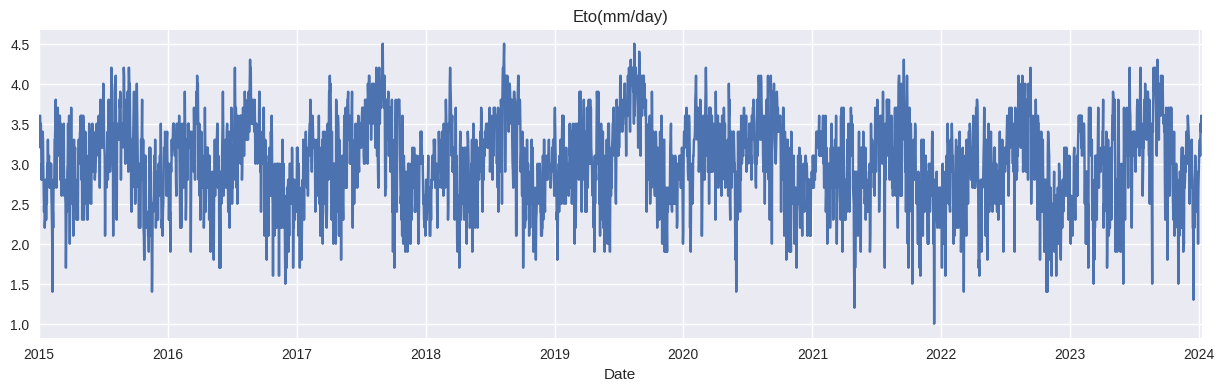

In [23]:
from matplotlib import pyplot as plt
df_time_series_ETo['Eto(mm/day)'].plot(kind='line', figsize=(15, 4), title='Eto(mm/day)')
plt.gca().spines[['top', 'right']].set_visible(False)

In [24]:
print("Number of missing values: ", df_time_series_ETo.isnull().sum().sum())
print("Número de valores na: "),df_time_series_ETo.isna().sum()

Number of missing values:  0
Número de valores na: 


(None,
 Eto(mm/day)    0
 dtype: int64)

<ipython-input-25-23844f7fd7eb>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_time_series_ETo['Eto(mm/day)'])


<Axes: xlabel='Eto(mm/day)', ylabel='Density'>

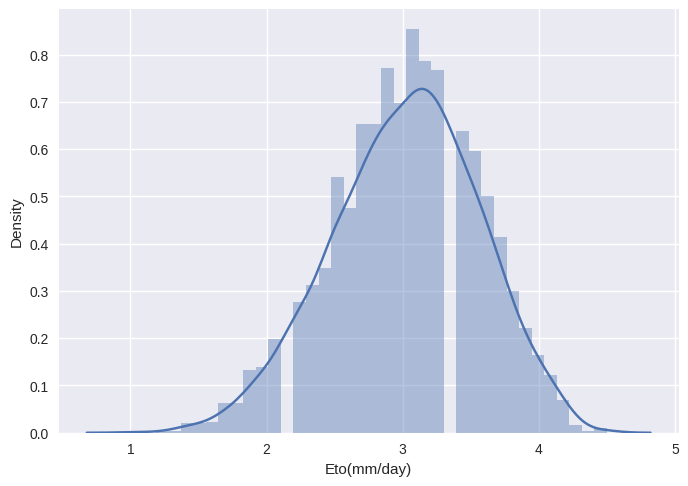

In [25]:
sns.distplot(df_time_series_ETo['Eto(mm/day)'])

#Exploración del Conjunto de Datos

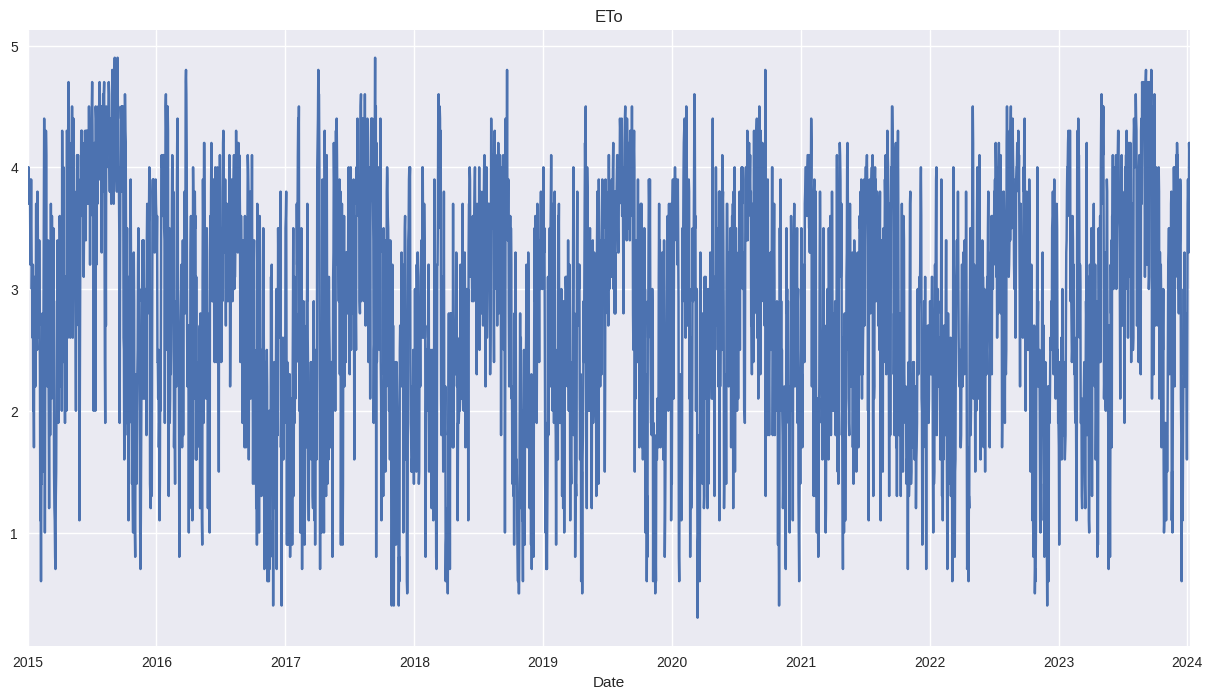

In [ ]:
df_time_series_ETo['Eto(mm/day)'].plot(kind='line', figsize=(15, 8), title='ETo')
plt.gca().spines[['top', 'right']].set_visible(False)

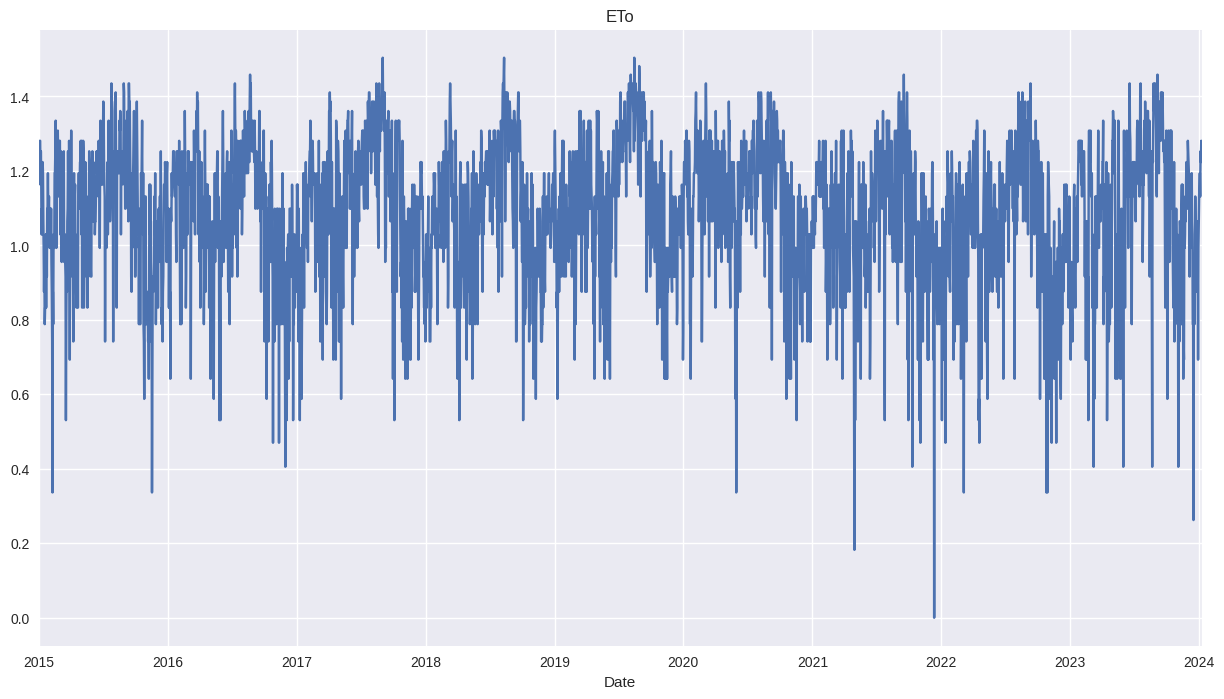

In [26]:
df_time_series_ETo['ETo_log']= np.log(df_time_series_ETo['Eto(mm/day)'])
df_time_series_ETo['ETo_log'].plot(kind='line', figsize=(15, 8), title='ETo')
plt.gca().spines[['top', 'right']].set_visible(False)

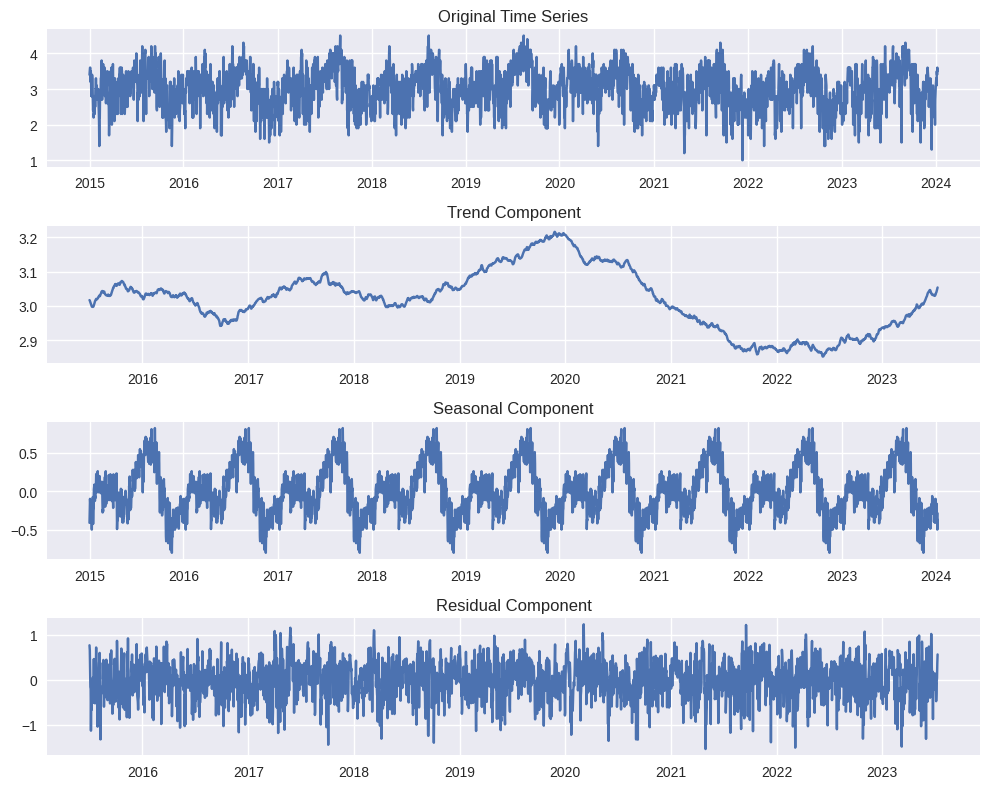

In [27]:
df_time_series_ETo.index = pd.to_datetime(df_time_series_ETo.index)

# Perform seasonal decomposition
result = seasonal_decompose(df_time_series_ETo['Eto(mm/day)'], model='additive', period=365)

# Plot the components
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

# Original time series
axes[0].plot(df_time_series_ETo.index, df_time_series_ETo['Eto(mm/day)'], label='Original')
axes[0].set_title('Original Time Series')

# Trend component
axes[1].plot(result.trend, label='Trend')
axes[1].set_title('Trend Component')

# Seasonal component
axes[2].plot(result.seasonal, label='Seasonal')
axes[2].set_title('Seasonal Component')

# Residual component
axes[3].plot(result.resid, label='Residual')
axes[3].set_title('Residual Component')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


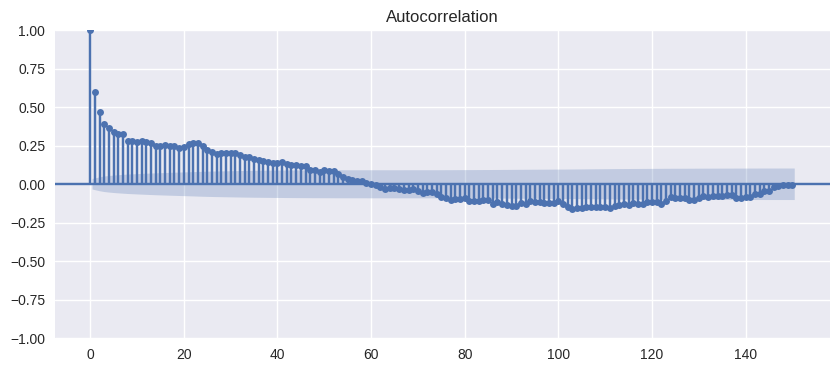

In [28]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df_time_series_ETo['Eto(mm/day)'], ax=ax, lags=150)
plt.show()

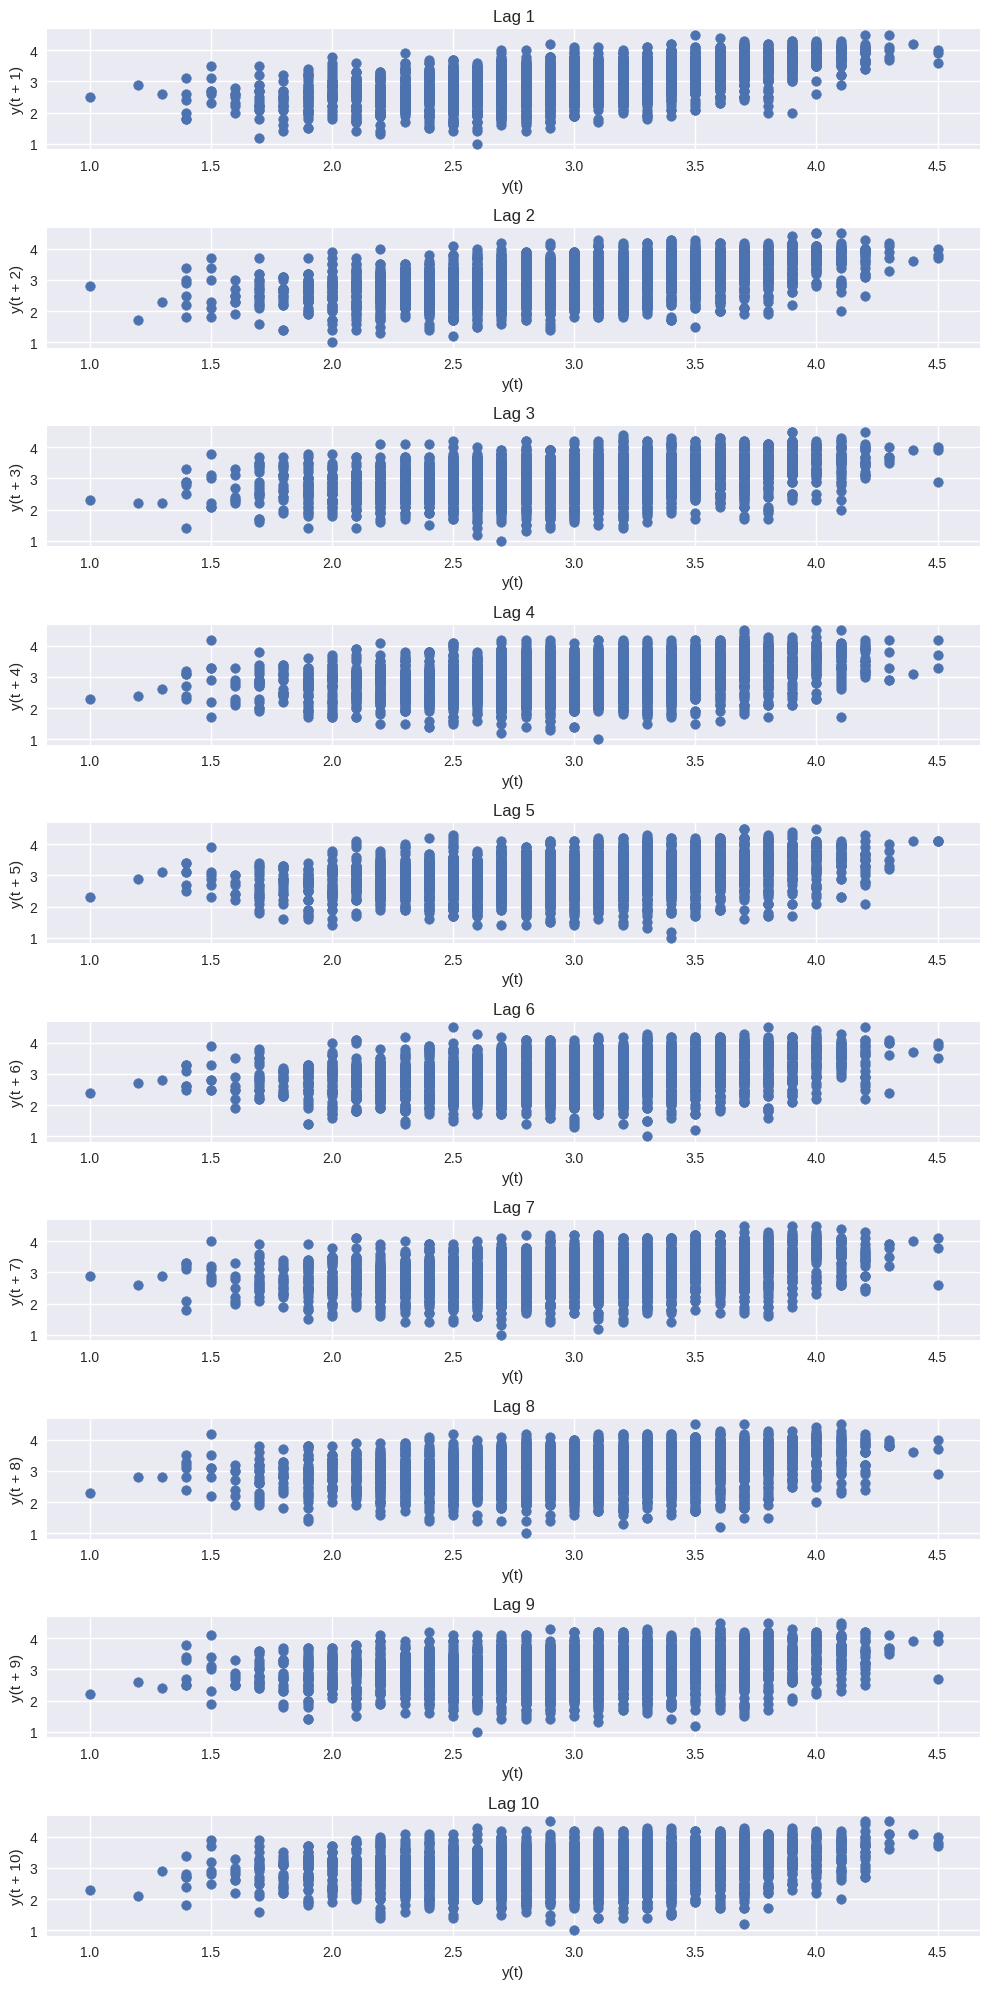

In [29]:
# Generate lag plots for the first 10 lags
lags = 10

# Create subplots
fig, axes = plt.subplots(nrows=lags, ncols=1, figsize=(10, 2 * lags))

# Loop through the lags and plot each on a separate subplot
for lag in range(1, lags + 1):
    lag_plot(df_time_series_ETo['Eto(mm/day)'], lag=lag, ax=axes[lag - 1])
    axes[lag - 1].set_title(f'Lag {lag}')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

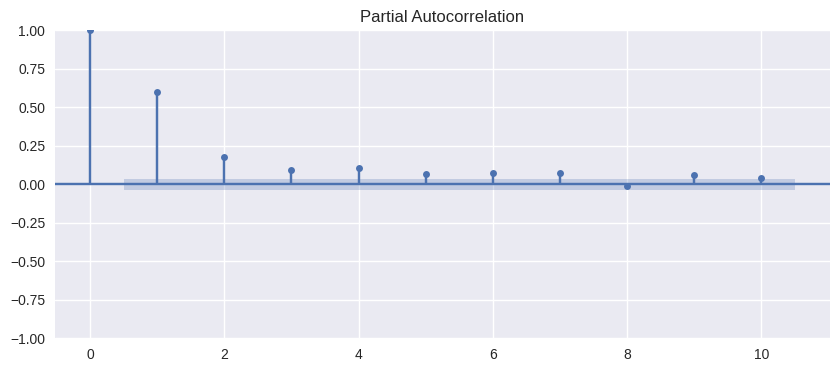

In [30]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(df_time_series_ETo['Eto(mm/day)'], ax=ax, lags=10, method='ywm')
plt.show()

In [31]:
def adf_test(x):
    result = adfuller(x)
    pvalue= result[1]
    print(pvalue)
    if pvalue < 0.05:
        print("Estacionaria")
    else:
        print("NO estacionaria")

In [32]:
adf_test(df_time_series_ETo['Eto(mm/day)'])

2.9608688772258685e-07
Estacionaria


In [33]:
result = adfuller(df_time_series_ETo['Eto(mm/day)'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.8886027956858
n_lags: 2.9608688772258685e-07
p-value: 2.9608688772258685e-07
Critial Values:
   1%, -3.43234952216411
Critial Values:
   5%, -2.862423470012863
Critial Values:
   10%, -2.567240289714035


#Machine Learning

Dates Train      : 2015-01-01 00:00:00 --- 2021-10-07 00:00:00  (n=2472)
Dates Validation : 2021-10-08 00:00:00 --- 2023-02-13 00:00:00  (n=494)
Dates Test       : 2023-02-14 00:00:00 --- 2024-01-09 00:00:00  (n=330)


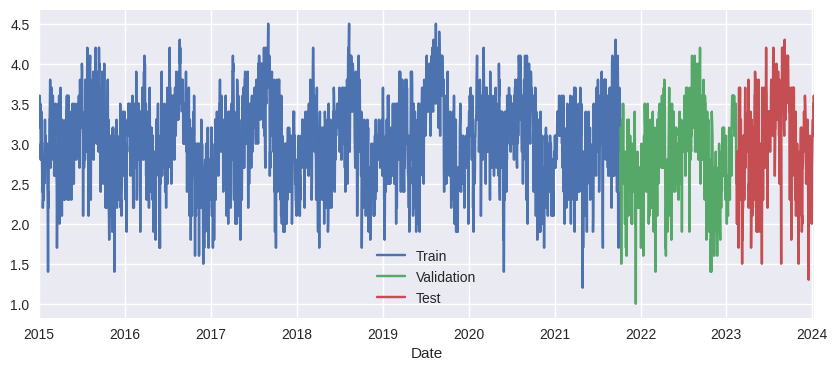

In [42]:
samples_training = int(len(df_time_series_ETo) * 0.75)
samples_validation = int(len(df_time_series_ETo) * 0.15)
data_train = df_time_series_ETo.iloc[:samples_training]
data_valid = df_time_series_ETo.iloc[samples_training:samples_training + samples_validation]
data_test = df_time_series_ETo.iloc[samples_training + samples_validation:]
print(f"Dates Train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates Validation : {data_valid.index.min()} --- {data_valid.index.max()}  (n={len(data_valid)})")
print(f"Dates Test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")
fig, ax = plt.subplots(figsize=(10, 4))
data_train['Eto(mm/day)'].plot(ax=ax, label='Train')
data_valid['Eto(mm/day)'].plot(ax=ax, label='Validation')
data_test['Eto(mm/day)'].plot(ax=ax, label='Test')
ax.legend();

##Modelo Base (Baseline)

In [43]:
# Random walk simulation
# ==============================================================================
df_rw = df_time_series_ETo.copy()
df_rw['pred_ETo'] = df_rw['Eto(mm/day)'].shift(1)

# Test error
# ==============================================================================
end_train='2023-02-12'
y_true = df_rw.loc[end_train:, 'Eto(mm/day)']
y_pred = df_rw.loc[end_train:, 'pred_ETo']
metric = mean_absolute_error(y_true, y_pred)

print(f'Test error: {metric}')
display(df_rw.loc[end_train:,].tail(4))

Test error: 0.4006024096385542


,Eto(mm/day),ETo_log,pred_ETo
Date,,,
2024-01-06,3.5,1.252763,3.1
2024-01-07,3.4,1.223775,3.5
2024-01-08,3.6,1.280934,3.4
2024-01-09,3.5,1.252763,3.6


In [44]:
print('MSE:',mean_squared_error(y_true,y_pred))
print('RMSE:',mean_squared_error(y_true,y_pred,squared=False))
print('MAPE:',mean_absolute_percentage_error(y_true,y_pred))
print('MAE:', mean_absolute_error(y_true,y_pred))

MSE: 0.27114457831325306
RMSE: 0.5207154485064305
MAPE: 0.14678741649800142
MAE: 0.4006024096385542


## LGBMRegressor

*Escenario* 1

In [152]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = 9,
                 transformer_y = StandardScaler()

             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df_time_series_ETo.iloc[:samples_training + samples_validation, df_time_series_ETo.columns.get_loc('Eto(mm/day)')])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [1 2 3 4 5 6 7 8 9] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 9 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-01-01 00:00:00'), Timestamp('2023-02-13 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-05-30 05:19:35 
L

In [153]:
predictions_LGMB= forecaster.predict(steps=len(data_test['Eto(mm/day)']))

In [154]:
print('MSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions_LGMB))
print('RMSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions_LGMB,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['Eto(mm/day)'],predictions_LGMB))
print('MAE:', mean_absolute_error(data_test['Eto(mm/day)'],predictions_LGMB))

MSE: 0.39574717162541934
RMSE: 0.6290843914972135
MAPE: 0.17982519338987066
MAE: 0.5223259615985794


In [155]:
# Backtest model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_ETo['Eto(mm/day)'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_ETo.iloc[:samples_training + samples_validation]),
                          refit              = False,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2966
Number of observations used for backtesting: 330
    Number of folds: 110
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-14 00:00:00 -- 2023-02-16 00:00:00  (n=3)
Fold: 1
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-17 00:00:00 -- 2023-02-19 00:00:00  (n=3)
Fold: 2
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-20 00:00:00 -- 2023-02-22 00:00:00  (n=3)
Fold: 3
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-23 00:00:00 -- 2023-02-25 00:00:00  (n=3)
Fold: 4
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-26 00:00:00 

  0%|          | 0/110 [00:00<?, ?it/s]

,pred
2023-02-14,2.837580
2023-02-15,2.884771
2023-02-16,2.857072
2023-02-17,2.619730
2023-02-18,2.516333


In [156]:
print('MSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions))
print('RMSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['Eto(mm/day)'],predictions))
print('MAE:', mean_absolute_error(data_test['Eto(mm/day)'],predictions))

MSE: 0.2727174224615396
RMSE: 0.5222235368705049
MAPE: 0.15229222964232667
MAE: 0.4151925275220402


Text(0.5, 1.0, 'Comparison of data_test and predictions')

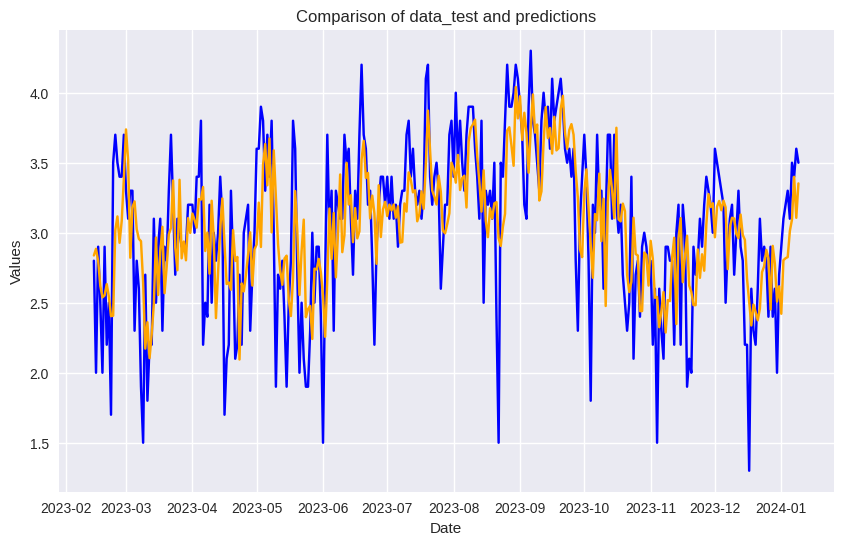

In [91]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plotting data_test
plt.plot(data_test.index, data_test['Eto(mm/day)'], label='data_test', color='blue')

# Plotting predictions
plt.plot(predictions.index, predictions['pred'], label='predictions', color='orange')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison of data_test and predictions')

Escenario 2, Hiperparametros usando conjunto de validación.

In [157]:
# Hyperparameters search
# ==============================================================================
# Lags grid
lags_grid = [1,2,3,4,5,10,20,30,40,50,60]

# Regressor hyperparameters

param_distributions = {
    'max_depth': np.arange(start=-1, stop=10, step=1, dtype=int),
    'learning_rate'    : [0.001, 0.01, 0.1, 0.5],
    'n_estimators'     : [50,100,200, 500, 1000],
}


results_search = random_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = df_time_series_ETo.iloc[:samples_training + samples_validation, df_time_series_ETo.columns.get_loc('Eto(mm/day)')], # Test data not used
                                   steps                = 3,
                                   lags_grid            = lags_grid,
                                   param_distributions  = param_distributions,
                                   n_iter               = 10,
                                   metric               = 'mean_squared_error',
                                   refit                = False,
                                   initial_train_size   = len(df_time_series_ETo.iloc[:samples_training]),
                                   fixed_train_size     = False,
                                   return_best          = True,
                                   random_state         = 123,
                                   n_jobs               = 'auto',
                                   verbose              = False,
                                   show_progress        = True
                               )

Number of models compared: 110.


lags grid:   0%|          | 0/11 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.01}
  Backtesting metric: 0.21031570010838394



In [158]:
results_search.head(10)

,lags,lags_label,params,mean_squared_error,n_estimators,max_depth,learning_rate
74,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.210316,1000.0,3.0,0.01
104,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.210847,1000.0,3.0,0.01
94,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.211430,1000.0,3.0,0.01
64,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.213893,1000.0,3.0,0.01
84,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.214293,1000.0,3.0,0.01
54,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.215597,1000.0,3.0,0.01
75,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 1, 'learni...",0.222150,1000.0,1.0,0.50
85,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 1, 'learni...",0.223282,1000.0,1.0,0.50
24,"[1, 2, 3]","[1, 2, 3]","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.224200,1000.0,3.0,0.01
14,"[1, 2]","[1, 2]","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.226604,1000.0,3.0,0.01


In [159]:
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.01, max_depth=3, n_estimators=1000,
              random_state=15926, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 30 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-01-01 00:00:00'), Timestamp('2023-02-13 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0

In [160]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_ETo['Eto(mm/day)'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_ETo.iloc[:samples_training + samples_validation]),
                          refit              = False,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2966
Number of observations used for backtesting: 330
    Number of folds: 110
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-14 00:00:00 -- 2023-02-16 00:00:00  (n=3)
Fold: 1
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-17 00:00:00 -- 2023-02-19 00:00:00  (n=3)
Fold: 2
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-20 00:00:00 -- 2023-02-22 00:00:00  (n=3)
Fold: 3
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-23 00:00:00 -- 2023-02-25 00:00:00  (n=3)
Fold: 4
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-26 00:00:00 

  0%|          | 0/110 [00:00<?, ?it/s]

,pred
2023-02-14,2.962259
2023-02-15,3.064269
2023-02-16,3.188273
2023-02-17,2.912521
2023-02-18,2.963330


In [161]:
print('MSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions))
print('RMSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['Eto(mm/day)'],predictions))
print('MAE:', mean_absolute_error(data_test['Eto(mm/day)'],predictions))

MSE: 0.2676776692879748
RMSE: 0.5173757525125958
MAPE: 0.15035581963633096
MAE: 0.40485922157063453


Guardar Modelo

In [ ]:
import pickle

In [ ]:
filename = 'modelo_ETo.pkl'
pickle.dump(forecaster, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open('modelo_ETo.pkl', 'rb'))

In [ ]:
last_window = df_time_series_ETo['Eto(mm/day)'].tail(50)

In [ ]:
input_data = (3)
prediction = loaded_model.predict(input_data,last_window=last_window)
print(prediction)

2024-01-09    4.090983
2024-01-10    3.883074
2024-01-11    3.778455
Freq: D, Name: pred, dtype: float64


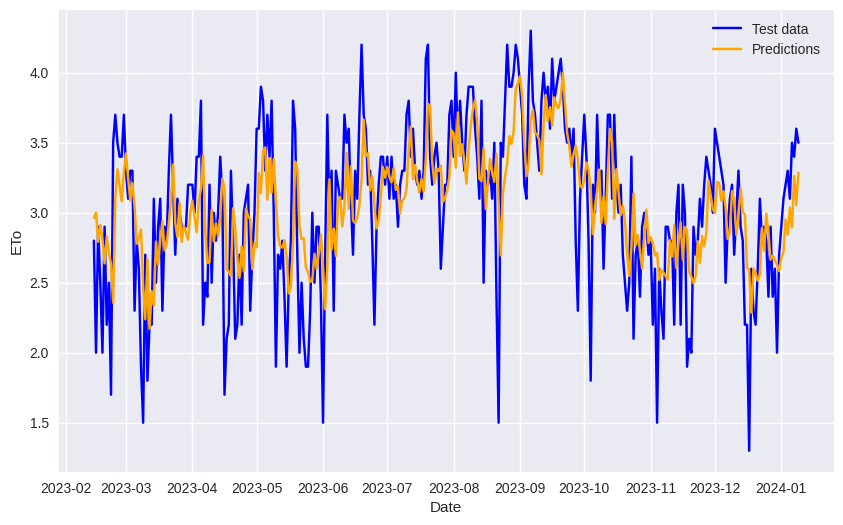

In [66]:
plt.figure(figsize=(10, 6))

plt.plot(data_test.index, data_test['Eto(mm/day)'], label='Test data', color='blue')
plt.plot(predictions.index, predictions['pred'], label='Predictions', color='orange')
plt.xlabel('Date')
plt.ylabel('ETo')
#plt.title('Comparison of data_test and predictions')
plt.legend()
plt.show()

Escenario 3, el backtesting usando refit con intermitencia de

In [162]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_ETo['Eto(mm/day)'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_ETo.iloc[:samples_training + samples_validation]),
                          allow_incomplete_fold = True,
                          refit              = 15,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2966
Number of observations used for backtesting: 330
    Number of folds: 110
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-14 00:00:00 -- 2023-02-16 00:00:00  (n=3)
Fold: 1
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-17 00:00:00 -- 2023-02-19 00:00:00  (n=3)
Fold: 2
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-20 00:00:00 -- 2023-02-22 00:00:00  (n=3)
Fold: 3
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-23 00:00:00 -- 2023-02-25 00:00:00  (n=3)
Fold: 4
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-26 00:00:00 

  0%|          | 0/110 [00:00<?, ?it/s]

,pred
2023-02-14,2.962259
2023-02-15,3.064269
2023-02-16,3.188273
2023-02-17,2.912521
2023-02-18,2.963330


In [163]:
print('MSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions))
print('RMSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['Eto(mm/day)'],predictions))
print('MAE:', mean_absolute_error(data_test['Eto(mm/day)'],predictions))

MSE: 0.26647837527065793
RMSE: 0.5162154349403532
MAPE: 0.14908229541202578
MAE: 0.40110019553290066


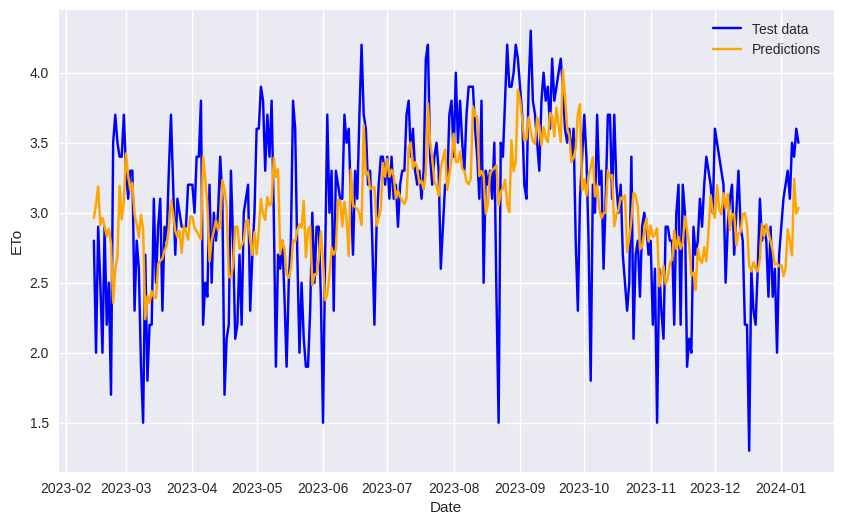

In [164]:
plt.figure(figsize=(10, 6))

plt.plot(data_test.index, data_test['Eto(mm/day)'], label='Test data', color='blue')
plt.plot(predictions.index, predictions['pred'], label='Predictions', color='orange')
plt.xlabel('Date')
plt.ylabel('ETo')
#plt.title('Comparison of data_test and predictions')
plt.legend()
plt.show()

In [165]:
import pickle

In [166]:
filename = 'modelo_ETo.pkl'
pickle.dump(forecaster, open(filename, 'wb'))

In [167]:
loaded_model = pickle.load(open('modelo_ETo.pkl', 'rb'))


##Random Forest

In [138]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 9,
                 #transformer_y = StandardScaler()
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df_time_series_ETo.iloc[:samples_training + samples_validation, df_time_series_ETo.columns.get_loc('Eto(mm/day)')])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8 9] 
Transformer for y: None 
Transformer for exog: None 
Window size: 9 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-01-01 00:00:00'), Timestamp('2023-02-13 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-30 05:06:57 
Last fit date: 2024-05-30 05:07:02 
Skforecast version: 0.12.1 
Python vers

In [139]:
predictions_RF= forecaster.predict(steps=len(data_test['Eto(mm/day)']))
print('MSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions_RF))
print('RMSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions_RF,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['Eto(mm/day)'],predictions_RF))
print('MAE:', mean_absolute_error(data_test['Eto(mm/day)'],predictions_RF))

MSE: 0.3616920454545458
RMSE: 0.6014083849220476
MAPE: 0.17440161732665105
MAE: 0.4927484848484852


In [140]:
# Backtest model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_ETo['Eto(mm/day)'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_ETo.iloc[:samples_training + samples_validation]),
                          refit              = False,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2966
Number of observations used for backtesting: 330
    Number of folds: 110
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-14 00:00:00 -- 2023-02-16 00:00:00  (n=3)
Fold: 1
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-17 00:00:00 -- 2023-02-19 00:00:00  (n=3)
Fold: 2
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-20 00:00:00 -- 2023-02-22 00:00:00  (n=3)
Fold: 3
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-23 00:00:00 -- 2023-02-25 00:00:00  (n=3)
Fold: 4
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-26 00:00:00 

  0%|          | 0/110 [00:00<?, ?it/s]

,pred
2023-02-14,3.012
2023-02-15,3.024
2023-02-16,2.939
2023-02-17,2.852
2023-02-18,2.838


In [141]:
print('MSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions))
print('RMSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['Eto(mm/day)'],predictions))
print('MAE:', mean_absolute_error(data_test['Eto(mm/day)'],predictions))

MSE: 0.2678385606060606
RMSE: 0.517531217035321
MAPE: 0.14746333733763822
MAE: 0.40085757575757575


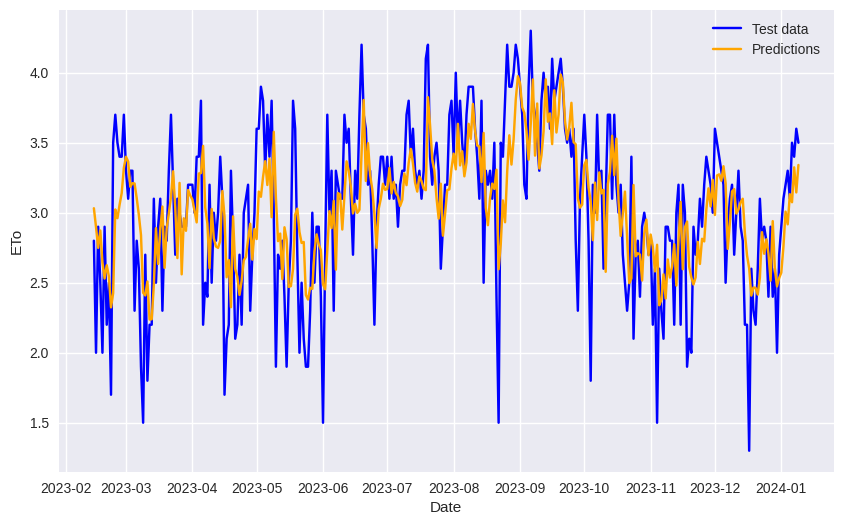

In [78]:
plt.figure(figsize=(10, 6))

plt.plot(data_test.index, data_test['Eto(mm/day)'], label='Test data', color='blue')
plt.plot(predictions.index, predictions['pred'], label='Predictions', color='orange')
plt.xlabel('Date')
plt.ylabel('ETo')
#plt.title('Comparison of data_test and predictions')
plt.legend()
plt.show()

Escenario 2

In [142]:
# Hyperparameters search
# ==============================================================================
# Lags grid
lags_grid = [1,2,3,4,5,10,20,30,40,50,60]

# Regressor hyperparameters

param_distributions = {
    'n_estimators': np.arange(start=10, stop=150, step=1, dtype=int),
    'max_depth': [None, 3,5,10,20,30],
    'max_features': [1,3,5,7,9],
}


results_search = random_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = df_time_series_ETo.iloc[:samples_training + samples_validation, df_time_series_ETo.columns.get_loc('Eto(mm/day)')], # Test data not used
                                   steps                = 3,
                                   lags_grid            = lags_grid,
                                   param_distributions  = param_distributions,
                                   n_iter               = 10,
                                   metric               = 'mean_squared_error',
                                   refit                = False,
                                   initial_train_size   = len(df_time_series_ETo.iloc[:samples_training]),
                                   fixed_train_size     = False,
                                   return_best          = True,
                                   random_state         = 123,
                                   n_jobs               = 'auto',
                                   verbose              = False,
                                   show_progress        = True
                               )

Number of models compared: 110.


lags grid:   0%|          | 0/11 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] 
  Parameters: {'n_estimators': 119, 'max_features': 9, 'max_depth': 30}
  Backtesting metric: 0.21238664253919368



In [143]:
results_search.head(10)

,lags,lags_label,params,mean_squared_error,n_estimators,max_features,max_depth
87,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 119, 'max_features': 9, 'max_...",0.212387,119.0,9.0,30.0
97,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 119, 'max_features': 9, 'max_...",0.212502,119.0,9.0,30.0
76,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 93, 'max_features': 9, 'max_d...",0.212948,93.0,9.0,30.0
86,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 93, 'max_features': 9, 'max_d...",0.213293,93.0,9.0,30.0
81,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 104, 'max_features': 9, 'max_...",0.213484,104.0,9.0,20.0
77,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 119, 'max_features': 9, 'max_...",0.213707,119.0,9.0,30.0
101,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 104, 'max_features': 9, 'max_...",0.214328,104.0,9.0,20.0
96,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 93, 'max_features': 9, 'max_d...",0.214339,93.0,9.0,30.0
91,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 104, 'max_features': 9, 'max_...",0.214504,104.0,9.0,20.0
71,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 104, 'max_features': 9, 'max_...",0.215094,104.0,9.0,20.0


In [144]:
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=30, max_features=9, n_estimators=119,
                      random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] 
Transformer for y: None 
Transformer for exog: None 
Window size: 40 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-01-01 00:00:00'), Timestamp('2023-02-13 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 9, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 119, 'n_jobs': None, 'oob_score': False, 'random_state'

In [150]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_ETo['Eto(mm/day)'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_ETo.iloc[:samples_training + samples_validation]),
                          refit              = False,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2966
Number of observations used for backtesting: 330
    Number of folds: 110
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-14 00:00:00 -- 2023-02-16 00:00:00  (n=3)
Fold: 1
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-17 00:00:00 -- 2023-02-19 00:00:00  (n=3)
Fold: 2
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-20 00:00:00 -- 2023-02-22 00:00:00  (n=3)
Fold: 3
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-23 00:00:00 -- 2023-02-25 00:00:00  (n=3)
Fold: 4
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-26 00:00:00 

  0%|          | 0/110 [00:00<?, ?it/s]

,pred
2023-02-14,3.011765
2023-02-15,2.954622
2023-02-16,3.000000
2023-02-17,2.991597
2023-02-18,3.008403


In [151]:
print('MSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions))
print('RMSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['Eto(mm/day)'],predictions))
print('MAE:', mean_absolute_error(data_test['Eto(mm/day)'],predictions))

MSE: 0.26678739739153395
RMSE: 0.5165146632880173
MAPE: 0.15022211807981573
MAE: 0.40631040800158447


Escenario 3

In [147]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_ETo['Eto(mm/day)'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_ETo.iloc[:samples_training + samples_validation]),
                          allow_incomplete_fold = True,
                          refit              = 15,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2966
Number of observations used for backtesting: 330
    Number of folds: 110
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-14 00:00:00 -- 2023-02-16 00:00:00  (n=3)
Fold: 1
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-17 00:00:00 -- 2023-02-19 00:00:00  (n=3)
Fold: 2
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-20 00:00:00 -- 2023-02-22 00:00:00  (n=3)
Fold: 3
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-23 00:00:00 -- 2023-02-25 00:00:00  (n=3)
Fold: 4
    Training:   2015-01-01 00:00:00 -- 2023-02-13 00:00:00  (n=2966)
    Validation: 2023-02-26 00:00:00 

  0%|          | 0/110 [00:00<?, ?it/s]

,pred
2023-02-14,3.011765
2023-02-15,2.954622
2023-02-16,3.000000
2023-02-17,2.991597
2023-02-18,3.008403


In [148]:
print('MSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions))
print('RMSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['Eto(mm/day)'],predictions))
print('MAE:', mean_absolute_error(data_test['Eto(mm/day)'],predictions))

MSE: 0.27215533197031333
RMSE: 0.5216850888901401
MAPE: 0.15132248902975542
MAE: 0.4087373258549729
